In [1]:
import pyarrow as pa
import pandas as pd
import netCDF4
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.colors import ListedColormap
import datetime as dt
from datetime import datetime
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import itertools
# pd.options.display.float_format = '{:.2f}'.format

C:\Users\YKlysa\AppData\Local\Temp\ipykernel_18612\479257975.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Functions

In [2]:
def read_chdet_output(res_cd):
    """
    Reads change detection output, filters relevant columns and converts the df into geo df.

    Arguments:
        path: path to the file
    Returns:
        geodataframe of the output
    """
    # res_cd = pd.read_csv(path)
    res_cd = res_cd[['detected_breakpoint', 'd_prob', 'lat', 'lon']]
    res_cd['detected_breakpoint'] = pd.to_datetime(res_cd['detected_breakpoint'].astype(str), format='%Y%m%d')
    gdf_rescd = gpd.GeoDataFrame(res_cd, geometry=gpd.points_from_xy(res_cd['lon'], res_cd['lat'], crs="EPSG:4326"), crs="EPSG:4326")
    return gdf_rescd

def convert_weather(path, save=True):
    """
    Reads the weather data from original .nc files; merges all the features together in the geodataset.

    Arguments:
        path: path to the directory, where all the weather files are located.
        save: a flag whether to save a merged dataset into a parquet file (to have all features together)
    Returns:
        geodataframe with weather features 
    """
    df_temp = xr.open_dataset(f'{path}INCA_2010_2022_temp.nc').to_dataframe().drop("spatial_ref", axis=1).dropna()
    df_wind = xr.open_dataset(f'{path}INCA_2010_2022_wind.nc').to_dataframe().drop("spatial_ref", axis=1).dropna()
    df_prec = xr.open_dataset(f'{path}INCA_2010_2022_prec.nc').to_dataframe().drop("spatial_ref", axis=1).dropna()
    # df_mslp = xr.open_dataset('./weather_data/INCA_2010_2022_mslp.nc').to_dataframe().drop("spatial_ref", axis=1)
    df_rhum = xr.open_dataset(f'{path}INCA_2010_2022_relative_humidity.nc').to_dataframe().drop("spatial_ref", axis=1).dropna()

    if (df_temp.shape == df_wind.shape == df_prec.shape == df_rhum.shape):
        df_weather = df_temp.copy()
        df_weather['wind'] = df_wind.wind
        df_weather['prec'] = df_prec.prec
        df_weather['relative_humidity'] = df_rhum.relative_humidity
    else:
        df_weather = pd.merge(
            df_temp, df_wind, left_index=True, right_index=True).merge(
                df_prec, left_index=True, right_index=True).merge(
                    df_rhum, left_index=True, right_index=True)#.merge(df_mslp, left_index=True, right_index=True)
    
    df_weather.reset_index(inplace=True)
    gdf_weather = gpd.GeoDataFrame(df_weather, geometry=gpd.points_from_xy(df_weather['x'], df_weather['y'], crs="EPSG:3416"), crs="EPSG:3416") # metres
    gdf_weather.drop(['x', 'y'], axis=1, inplace=True)
    gdf_weather = gdf_weather.to_crs(epsg=4326)
    if save:
        gdf_weather.to_parquet("gdf_weather_2010_2022.parquet")
    return gdf_weather

def read_inventory(path, crs=4326, date_start='2010-01-01', date_end='2023-01-01'):
    """
    Returns inventory filtered by relevant time period.

    Arguments:
        path: a path to the inventory file
        crs: crs to what the file should be converted, default is lon lat coordinates in 4326
        date_start: the start date of relevant time period
        date_end: the end date of relevant time period
    Returns:
        filtered inventory
    """
    inventory = gpd.read_file(path)
    inventory = inventory.to_crs(crs)
    inventory = inventory[~inventory.TYP_CODE.isin(['Bergsturz', 'Blocksturz', 'Erdfall', 'Felssturz', 'Steinschlag'])]
    inventory = inventory[['OBJEKTID', 'EREIG_ZEIT', 'geometry']]

    # the dates are not clean: some are day.month.year, some are month.year, some are only estimated year of event
    date1 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%Y')
    date2 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%m.%Y')
    date3 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%d.%m.%Y')
    date3 = date3.fillna(date2)
    date3 = date3.fillna(date1)
    inventory['EREIG_ZEIT'] = date3
    return inventory[inventory.EREIG_ZEIT >= date_start][inventory.EREIG_ZEIT < date_end]

def read_weather(path):
    """
    Reads weather geodataframe in .parquet format. No extra processing

    Arguments:
        path: path to the file
    Returns:
        geodataframe
    """
    df_won_weather = gpd.read_parquet(path)
    return df_won_weather

def merge_weather_landslide(landslide_data: pd.DataFrame, weather_data: pd.DataFrame):
    """
    Merging of landslide point and unique geo points from weather data.
    Sets the landslide column in weather data to 0, for EREIG_ZEIT date - 1

    Arguments:
        landslide_data: landslide inventory geodataframe
        weather_data: weather geodataframe
    Returns:
        merged data by geospatial sjoin
    """
    common_points = gpd.sjoin_nearest(landslide_data, weather_data[weather_data.time == "2018-04-01"], how='inner', lsuffix='inv', rsuffix='weather')
    land_filtered = common_points[['OBJEKTID', 'EREIG_ZEIT', 'geometry', 'weath_geom']].reset_index(drop=True)
    
    weather_data["landslide"] = 0
    wd_land_only = pd.merge(weather_data, land_filtered, left_on='geometry', right_on='weath_geom').drop(['weath_geom_x', 'weath_geom_y'], axis=1)
    wd_land_only = wd_land_only.rename({'geometry_x':'geometry', 'geometry_y':'inv_geom'}, axis=1)
    wd_land_only.loc[wd_land_only.time == wd_land_only.EREIG_ZEIT, 'landslide'] = 1
    return wd_land_only

In [3]:
def calculate_features(time_window: pd.DataFrame, month_time: pd.DataFrame, features: list):
    """
    Calculation of time-wise features based on available weather conditions

    Arguments: 
        time_window: df of smaller time-period: usually 14 days
        month_time: df of larger time-period: usually 30 days
        features: the list of features to calculate. Possible options: prec, wind, mslp, relhum, temp
    Returns:
        dictionary of calculated weather features
    """
    cal_weather = {}
    if 'prec' in features:
        cal_weather['prec_max'] = [time_window.prec.max()]
        cal_weather['prec_mean'] = [time_window.prec.mean()]
        cal_weather['prec_min'] = [time_window.prec.min()]
        cal_weather['prec_kurt'] = [time_window.prec.kurtosis()]
        cal_weather['prec_kurt_month'] = [month_time.prec.kurtosis()]
        cal_weather['sum_prec'] = [time_window.prec.sum()]
        cal_weather['sum_prec_month'] = [month_time.prec.sum()]
        cal_weather['prec_skew'] = [time_window.prec.skew()]
        cal_weather['prec_skew_month'] = [month_time.prec.skew()]

    if 'wind' in features:
        cal_weather['wind_max'] = [time_window.wind.max()]
        cal_weather['wind_max_month'] = [month_time.wind.max()]
        cal_weather['wind_mean'] = [time_window.wind.mean()]
        cal_weather['wind_min'] = [time_window.wind.min()]
        cal_weather['wind_skew'] = [time_window.wind.skew()]
        cal_weather['wind_skew_month'] = [month_time.wind.skew()]
        cal_weather['wind_kurt'] = [time_window.wind.kurtosis()]
        cal_weather['wind_kurt_month'] = [month_time.wind.kurtosis()]
        cal_weather['wind_light'] = [len(time_window[time_window.wind <= 5])]
        cal_weather['wind_mod'] = [len(time_window[(time_window.wind > 5) & (time_window.wind <= 11)])]
        cal_weather['wind_strong'] = [len(time_window[(time_window.wind > 11) & (time_window.wind <= 17)])]
        cal_weather['wind_sev'] = [len(time_window[(time_window.wind > 17) & (time_window.wind <= 23)])]
        cal_weather['wind_extr'] = [len(time_window[time_window.wind > 23])]

    if 'mslp' in features:
        cal_weather['mslp_min'] = [time_window.mslp.min()]
        cal_weather['mslp_mean'] = [time_window.mslp.mean()]
        cal_weather['mslp_max'] = [time_window.mslp.max()]
        cal_weather['mslp_high'] = [len(time_window[time_window.mslp >= 102000])]
        cal_weather['mslp_norm'] = [len(time_window[(time_window.mslp > 101300) & (time_window.mslp < 102000)])]
        cal_weather['mslp_shall'] = [len(time_window[(time_window.mslp > 100000) & (time_window.mslp <= 101300)])]
        cal_weather['mslp_low'] = [len(time_window[(time_window.mslp > 98000) & (time_window.mslp <= 100000)])]
        cal_weather['mslp_verylow'] = [len(time_window[time_window.mslp <= 98000])]
        cal_weather['mslp_skew'] = [time_window.mslp.skew()]
        cal_weather['mslp_skew_month'] = [month_time.mslp.skew()]
        cal_weather['mslp_kurt'] = [time_window.mslp.kurtosis()]
        cal_weather['mslp_kurt_month'] = [month_time.mslp.kurtosis()]

    if 'relhum' in features:
        cal_weather['relhum_min'] = [time_window.relative_humidity.min()]
        cal_weather['relhum_mean'] = [time_window.relative_humidity.mean()]
        cal_weather['relhum_max'] = [time_window.relative_humidity.max()]
        cal_weather['relhum_veryhigh'] = [len(time_window[time_window.relative_humidity > 80])]
        cal_weather['relhum_high'] = [len(time_window[(time_window.relative_humidity >= 60) & (time_window.relative_humidity <= 80)])]
        cal_weather['relhum_norm'] = [len(time_window[(time_window.relative_humidity >= 30) & (time_window.relative_humidity < 60)])]
        cal_weather['relhum_low'] = [len(time_window[time_window.relative_humidity < 30])]
        cal_weather['relhum_skew'] = [time_window.relative_humidity.skew()]
        cal_weather['relhum_skew_month'] = [month_time.relative_humidity.skew()]
        cal_weather['relhum_kurt'] = [time_window.relative_humidity.kurtosis()]
        cal_weather['relhum_kurt_month'] = [month_time.relative_humidity.kurtosis()]

    if 'temp' in features:
        cal_weather['temp_skew'] = [time_window.temp.skew()]
        cal_weather['temp_skew_month'] = [month_time.temp.skew()]
        cal_weather['temp_max'] = [time_window.temp.max()]
        cal_weather['temp_min'] = [time_window.temp.min()]
        cal_weather['temp_mean'] = [time_window.temp.mean()]
        cal_weather['temp_mean_month'] = [month_time.temp.mean()]
        cal_weather['temp_kurt'] = [time_window.temp.kurtosis()]
        cal_weather['temp_kurt_month'] = [month_time.temp.kurtosis()]
        cal_weather['temp_std'] = [time_window.temp.std()]
    return cal_weather

def create_entry_for_points(df_w_data, n_days:int = 14, features:list=['prec', 'wind', 'mslp', 'relhum', 'temp']):
    """
    Creates a dataframe of weather analysis data on given points.

    Arguments:
        df_w_data: merged landslide with weather geodatarame
        n_days: number of days for the first time window
        features: the list of features to calculate
    Returns:
        Dataframe of calculated weather conditions before the event time of given points
    """
    uniquep_won = df_w_data.geometry.unique()
    new_entries = []
    for i in range(0, len(uniquep_won)):
        point = uniquep_won[i]
        X_data = df_w_data.loc[df_w_data['geometry'].isin([point])]
        X_data = X_data.reset_index(drop=True)

        land_dates = X_data[X_data.landslide == 1]
        try:
            print(land_dates.index)
            for idx in land_dates.index:
                time_window = X_data.iloc[idx-n_days : idx]
                month_time = X_data.iloc[idx-30 : idx]

                d = calculate_features(time_window, month_time, features)
                d['landslide'] = X_data.iloc[idx].landslide
                d['cd_prob'] = X_data.iloc[idx].d_prob
                new_entries.append(pd.DataFrame(d))

        except Exception as e:
            print(e)
    point_data = pd.concat(new_entries, ignore_index=True)
    return point_data

def create_df_for_train(df_w_data, uniquep_won, n_days:int = 14, start_point: int =0, final_point:int =None, step:int =3, num_from_one:int =5, features:list=['prec', 'wind', 'mslp', 'relhum', 'temp']):
    """
    Creates a dataframe of weather analysis data on landslide points with non-landslide entries for training.

    Arguments:
        df_w_data: merged landslide with weather geodatarame
        uniquep_won: all unique landslide spatial points
        n_days: number of days for the first time window
        start_point [int]: the starting point among unique points of landslide event, index of uniquep_won
        final_point [int]: the last landslide among unique points of landslide event considered for creating a dataset, index of uniquep_won
        step: number of days to step back from landslide event for creating non-landlide statistics
        num_from_one: how many time entries to create for non-landslide events
        features: the list of features to calculate
    Returns:
        Dataframe of calculated weather conditions with landslide and non-landslide points as target variable 
        and calculated weather features before event as independent variables for training dataset.
    """
    new_entries = []
    if final_point == None:
        final_point = len(uniquep_won)

    for i in range(start_point, final_point):
        point = uniquep_won[i]
        X_data = df_w_data.loc[df_w_data['geometry'].isin([point])]
        X_data = X_data.reset_index(drop=True)

        land_dates = X_data[X_data.landslide == 1]
        try:
            print(land_dates.index)
            for idx in land_dates.index:
                for j in range(0, num_from_one):
                    deviation = j*step

                    time_window = X_data.iloc[idx-n_days - deviation : idx - deviation]
                    month_time = X_data.iloc[idx-30 - deviation : idx - deviation]

                    d = calculate_features(time_window, month_time, features)
                    d['landslide'] = X_data.iloc[idx - deviation].landslide
                    new_entries.append(pd.DataFrame(d))

        except Exception as e:
            print(e)
    point_data = pd.concat(new_entries, ignore_index=True)
    return point_data

In [4]:
def divide_data(data: pd.DataFrame, new_feats: list, test_size: float=0.2):
    """
    Create training/test sets proportionally to the landslide and non-landslide events

    Arguments:
        new_feats: list of features used for the X data.
    Returns:
        X_train, X_val, y_train, y_val
    """
    analys_l = data[data.landslide == 1]
    analys_wl = data[data.landslide == 0]

    X_data_l = analys_l[new_feats]
    X_data_wl = analys_wl[new_feats]
    y_data_l = analys_l[["landslide"]]
    y_data_wl = analys_wl[["landslide"]]


    X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(X_data_l, y_data_l, test_size=test_size, random_state=1423)
    X_train_wl, X_val_wl, y_train_wl, y_val_wl = train_test_split(X_data_wl, y_data_wl, test_size=test_size, random_state=1423)
    X_train, X_val, y_train, y_val = pd.concat([X_train_l, X_train_wl]), pd.concat([X_val_l, X_val_wl]), pd.concat([y_train_l, y_train_wl]), pd.concat([y_val_l, y_val_wl])

    print((X_train.shape, X_val.shape, y_train.shape, y_val.shape))
    return X_train, X_val, y_train, y_val

In [5]:
def filter_first_features(f_num: int, X, y):
    """
    Feature selection based on f_classif

    Arguments:
        f_num: number of independent features that should be left
    """
    fclass = SelectKBest(f_classif, k=f_num).fit(X, y)
    X_new = pd.DataFrame(fclass.transform(X))
    mask = fclass.get_support()
    new_features = X.columns[mask]
    X_new = X[new_features]
    full_up_data = X_new.merge(y, left_index=True, right_index=True)
    return full_up_data

In [6]:
def run_feat_sel(full_train_data, new_feats: list, statistics_try: dict, num: int, indx: int =0, final: int =20):
    """
    Feature selection based on checking all possible options by eliminating 1 feature at a time

    Arguments:
        new_feats [list]: features of training dataset to consider for feature selection
        statistics_try [dict]: statistics of trying the features
        num: number of features to consider for the first run. Recommended: len(new_feats)-1
        indx: index of the features combinations to be reduced. Initialised: 0
        final: target number of number of features
    
    Returns:
        a dataframe of ststistics of feature elimination
    """
    if num == final:
        return statistics_try

    # create all possible combinations of eliminating column/-s to reach n number of columns from current one
    all_cols = full_train_data[new_feats]
    combinations = list(itertools.combinations(all_cols, num))
    print(num)
    print(f"len combs = {len(combinations)}")

    for j in range(0, len(combinations)):
        X_train, X_val, y_train, y_val = divide_data(full_train_data, list(combinations[j]))
        y_train = y_train['landslide']
        y_val = y_val['landslide']
        statistics_try['prev_index'].append(indx)
        statistics_try['features'].append(list(X_train.columns.values))
        rf = RandomForestClassifier(n_estimators = 600, random_state=42, max_depth=4, class_weight="balanced") # 6 - 66.3 recall
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_train)
        class_report_train = classification_report(y_train, y_pred_rf, output_dict=True)
        statistics_try['rf_acc_train'].append(class_report_train['accuracy'])
        statistics_try['rf_prec_1_train'].append(class_report_train['1']['precision'])
        statistics_try['rf_rec_1_train'].append(class_report_train['1']['recall'])
        statistics_try['rf_f1_1_train'].append(class_report_train['1']['f1-score'])

        y_pred_rf_val = rf.predict(X_val)
        class_report = classification_report(y_val, y_pred_rf_val, output_dict=True)
        statistics_try['rf_acc'].append(class_report['accuracy'])
        statistics_try['rf_prec_1'].append(class_report['1']['precision'])
        statistics_try['rf_rec_1'].append(class_report['1']['recall'])
        statistics_try['rf_f1_1'].append(class_report['1']['f1-score'])
    new_stats = pd.DataFrame.from_dict(statistics_try)

    # sort the results of RandomForest model for all tested combinations; choose 2 best
    indexes = new_stats[new_stats.prev_index == indx].sort_values(by=['rf_rec_1', 'rf_f1_1', 'rf_prec_1', 'rf_acc', 'rf_f1_1_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_acc_train'], ascending=False).head(2).index
    print(f"indxs = {indexes}")

    # for the 2 best run the elimination of 1 more feature
    for idx in indexes:
        if len(new_stats.iloc[idx].features) < len(new_feats):
            print(f"idx = {idx}")
            statistics_try = run_feat_sel(full_train_data, new_feats=new_stats.iloc[idx].features.copy(), statistics_try=statistics_try, num=num-1, indx=idx, final=final)
            print("after")
            print(statistics_try)
    return statistics_try

# Merge weather and landslide

In [17]:
# df_won_weather = convert_weather("./weather_data/", save=False)
df_won_weather = read_weather("gdf_weather_2010_2022.parquet")
df_won_weather['weath_geom'] = df_won_weather.geometry        # save geo point of weather data

another_inv3_filt = read_inventory("..\\..\\wp5\\Daten Massenbewegungen\Massenbewegungen im Detail\\Massenbewegungen_im_Detail.shp")
ww_land_only = merge_weather_landslide(another_inv3_filt, df_won_weather)

uniquep_won = ww_land_only.geometry.unique()
print(len(uniquep_won))

# ww_land_only.to_parquet('curr_ll_inv_20101001_2022_filtered.parquet')

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


432


In [7]:
curr_landsl = gpd.read_parquet('curr_ll_inv_20101001_2022_filtered.parquet')
uniquep_won = curr_landsl.geometry.unique()
analysis_data = create_df_for_train(curr_landsl, uniquep_won, step=30, num_from_one=5, features=['prec', 'wind', 'relhum', 'temp'])
# analysis_data.to_parquet('analysis_data_step30_on_newest_one.parquet')

Index([1515], dtype='int64')
Index([5861, 8371, 14652, 16846, 18967, 26361, 28794, 31768], dtype='int64')
Index([1038], dtype='int64')
Index([2826], dtype='int64')
Index([633, 2347, 7295, 7693, 8110, 12060, 27879], dtype='int64')
Index([5128, 5163, 5165], dtype='int64')
Index([1721], dtype='int64')
Index([3186], dtype='int64')
Index([6884, 6885, 6887, 7806], dtype='int64')
Index([3442, 3443], dtype='int64')
Index([2926], dtype='int64')
Index([2683], dtype='int64')
Index([2993, 6652], dtype='int64')
Index([2715], dtype='int64')
Index([1042], dtype='int64')
Index([3629], dtype='int64')
Index([1722], dtype='int64')
Index([2076, 2809], dtype='int64')
Index([4295], dtype='int64')
Index([4283, 6082, 8151], dtype='int64')
Index([3030, 4847], dtype='int64')
Index([7871, 8482, 13710], dtype='int64')
Index([1042], dtype='int64')
Index([1, 4239, 8732], dtype='int64')
Index([3054], dtype='int64')
Index([5163, 5164, 5165], dtype='int64')
Index([503, 4756, 8790, 11277], dtype='int64')
Index([1868, 5

In [8]:
# analysis_data.to_parquet('analysis_data_step30_womslp_from2010_filtered.parquet')

In [9]:
analysis_data

,prec_max,prec_mean,prec_min,prec_kurt,prec_kurt_month,sum_prec,sum_prec_month,prec_skew,prec_skew_month,wind_max,...,temp_skew,temp_skew_month,temp_max,temp_min,temp_mean,temp_mean_month,temp_kurt,temp_kurt_month,temp_std,landslide
0,38.749000,11.963000,0.0,-0.065481,0.346522,167.482000,291.423000,1.114454,1.219965,4.809262,...,0.739438,0.344939,4.918750,0.659167,2.459643,1.297667,-0.261753,-0.416690,1.295798,1
1,23.401000,2.944643,0.0,8.784413,5.867615,41.225000,182.977000,2.886410,2.487156,4.739420,...,-0.203361,0.358636,5.364583,-0.118333,2.942530,2.762097,-0.690149,0.240452,1.696321,0
2,0.225000,0.031643,0.0,3.802705,14.145365,0.443000,73.364000,2.296224,3.689636,3.816870,...,0.654693,0.410677,4.005000,-3.390833,-0.593631,-0.620222,-0.214235,-0.728235,2.191309,0
3,69.435000,8.379786,0.0,10.648083,14.835065,117.317000,195.012000,3.160351,3.579706,3.738074,...,0.023621,0.586802,8.477500,2.090417,5.368214,8.544986,0.995831,-0.865992,1.553559,0
4,14.636000,2.779429,0.0,1.564190,3.281855,38.912000,74.397000,1.696280,2.086001,4.983623,...,0.477370,0.167248,15.030833,6.504167,10.474524,11.288431,-0.947957,-1.028556,2.743656,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,20.500000,3.250000,0.0,3.756548,9.262803,45.500001,66.600001,2.248513,3.095577,4.900000,...,-0.679201,-0.340140,6.839583,1.042500,4.537887,1.651333,-0.519445,-0.702329,1.962913,1
4536,3.800000,0.935714,0.0,-0.212769,4.351358,13.100000,15.700000,1.257657,2.346180,3.800000,...,-2.110906,-0.848560,2.206667,-9.560833,-0.724375,-3.744306,5.664398,-0.149813,3.007758,0
4537,4.900000,0.628571,0.0,8.644177,1.871979,8.800000,55.500001,2.843349,1.702692,4.800000,...,0.614572,0.310045,1.257083,-7.063750,-3.853036,-3.009264,0.690125,-0.443494,2.262976,0
4538,33.200001,5.112929,0.0,4.452376,10.749047,71.581001,97.393001,2.197680,3.146760,3.200000,...,0.159072,-0.226823,1.490000,-2.711250,-0.717560,-1.205889,-1.653314,-0.143879,1.508420,0


# Create training / test sets

In [7]:
analysis_data = pd.read_parquet('analysis_data_step30_womslp_from2010_filtered.parquet')
analysis_data = analysis_data.dropna()

In [8]:
X_data, X_test, y_data, y_test = divide_data(analysis_data, analysis_data.drop(["landslide"], axis=1).columns, test_size=0.1)
full_data = X_data.merge(y_data, left_index=True, right_index=True)

((4081, 42), (454, 42), (4081, 1), (454, 1))


# Train a model

In [9]:
full_up_data = filter_first_features(30, X_data, y_data)
new_feats = full_up_data.drop(["landslide"], axis=1).columns

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
statistics_try = {'features': [], 'prev_index': [], 'rf_acc_train': [], 'rf_prec_1_train': [], 'rf_rec_1_train': [], 'rf_f1_1_train': [], 'rf_acc': [], 'rf_prec_1': [], 'rf_rec_1': [], 'rf_f1_1': []}
new_stats = pd.DataFrame.from_dict(run_feat_sel(full_up_data, new_feats, statistics_try, 29, 0, 26))
new_stats

29
len combs = 30
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (817, 1))
((3264, 29), (817, 29), (3264, 1), (8

,features,prev_index,rf_acc_train,rf_prec_1_train,rf_rec_1_train,rf_f1_1_train,rf_acc,rf_prec_1,rf_rec_1,rf_f1_1
0,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",0,0.814032,0.527141,0.670245,0.590142,0.789474,0.477612,0.588957,0.527473
1,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",0,0.811275,0.521480,0.670245,0.586577,0.784578,0.468293,0.588957,0.521739
2,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",0,0.811275,0.521429,0.671779,0.587131,0.784578,0.468599,0.595092,0.524324
3,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",0,0.810049,0.518913,0.673313,0.586115,0.783354,0.466019,0.588957,0.520325
4,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",0,0.809130,0.517241,0.667178,0.582719,0.782130,0.463768,0.588957,0.518919
...,...,...,...,...,...,...,...,...,...,...
195,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",134,0.809130,0.517241,0.667178,0.582719,0.789474,0.477612,0.588957,0.527473
196,"[prec_max, prec_mean, prec_min, prec_kurt_mont...",134,0.811887,0.522837,0.667178,0.586253,0.790698,0.480198,0.595092,0.531507
197,"[prec_max, prec_mean, prec_kurt, prec_kurt_mon...",134,0.809743,0.518474,0.667178,0.583501,0.785802,0.470588,0.588957,0.523161
198,"[prec_max, prec_min, prec_kurt, prec_kurt_mont...",134,0.813113,0.525547,0.662577,0.586160,0.796818,0.492228,0.582822,0.533708


,features,prev_index,rf_acc_train,rf_prec_1_train,rf_rec_1_train,rf_f1_1_train,rf_acc,rf_prec_1,rf_rec_1,rf_f1_1
110,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",33,0.808517,0.515789,0.676380,0.585269,0.793146,0.485294,0.607362,0.539510
103,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",33,0.809743,0.518086,0.680982,0.588469,0.790698,0.480583,0.607362,0.536585
165,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",143,0.806985,0.513002,0.665644,0.579439,0.790698,0.480583,0.607362,0.536585
162,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",143,0.804228,0.507638,0.662577,0.574850,0.790698,0.480583,0.607362,0.536585
163,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",143,0.803615,0.506403,0.667178,0.575778,0.789474,0.478261,0.607362,0.535135
199,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",134,0.803615,0.506403,0.667178,0.575778,0.789474,0.478261,0.607362,0.535135
111,"[prec_max, prec_mean, prec_min, prec_kurt_mont...",33,0.806985,0.512821,0.674847,0.582781,0.788250,0.475962,0.607362,0.533693
161,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",143,0.806679,0.512367,0.667178,0.579614,0.788250,0.475962,0.607362,0.533693
105,"[prec_max, prec_mean, prec_min, prec_kurt, pre...",33,0.806679,0.512111,0.680982,0.584595,0.785802,0.471429,0.607362,0.530831
143,"[prec_mean, prec_min, prec_kurt, prec_kurt_mon...",5,0.805453,0.509942,0.668712,0.578633,0.784578,0.469194,0.607362,0.529412


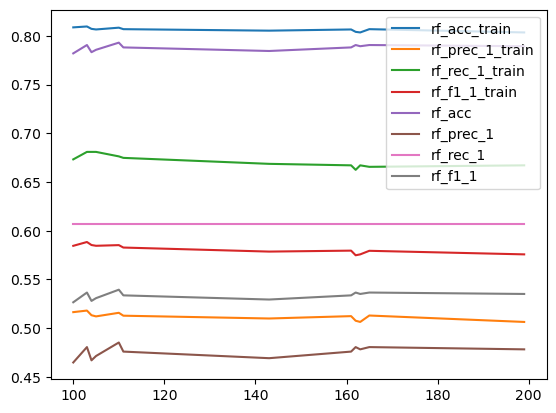

In [15]:
new_stats[new_stats.rf_rec_1 > new_stats.rf_rec_1.max()-0.005][['rf_acc_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_f1_1_train', 'rf_acc', 'rf_prec_1', 'rf_rec_1', 'rf_f1_1']].plot()
new_stats[new_stats.rf_rec_1 > new_stats.rf_rec_1.max()-0.005].sort_values(by=['rf_rec_1', 'rf_f1_1', 'rf_prec_1', 'rf_acc', 'rf_f1_1_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_acc_train', 'prev_index'], ascending=False)#.head(10)

In [17]:
def hyperp_tuning(X, y):
    """
    Hyperparameter tuning for Random Forest Classifier
    random_state = 42

    Returns:
        grid results
    """
    params = {'bootstrap': [False, True], #True
            'criterion':['gini', 'log_loss'], #, 'log_loss'
    'max_depth': [4, 5, 6, 7, 8, 10, 12, 15], #, 10, 40, 50, 60    , 30, None
    'max_features': ['log2', 'sqrt', None],  #, 'sqrt', None
    #  'min_samples_leaf': [1, 2, 4],
    #  'min_samples_split': [2, 5, 10], #10, 5
    'n_estimators': [300, 400, 500, 600, 700]} #, 1200, 2000, 1000, 1600     200, 600, 800,200, 400, 

    rf = RandomForestClassifier(random_state=42, class_weight="balanced")
    grid_search = GridSearchCV(estimator = rf, param_grid = params, cv = 3, n_jobs = -1, verbose = 2, refit='recall')
    grid_search.fit(X, y)
    return grid_search

new_feats = new_stats.iloc[110].features
grid_search = hyperp_tuning(X_data[new_feats], y_data)
pd.DataFrame.from_dict(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
234,41.976960,0.972516,0.396777,0.019509,False,log_loss,15,sqrt,700,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.883909,0.880147,0.890441,0.884832,0.004253,1
108,34.193022,2.967396,0.398463,0.063237,False,gini,15,log2,600,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.882439,0.882353,0.888971,0.884588,0.003099,2
228,29.491397,0.554808,0.316518,0.006052,False,log_loss,15,log2,600,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.883909,0.881618,0.888235,0.884587,0.002744,3
230,17.601441,0.195592,0.155888,0.006477,False,log_loss,15,sqrt,300,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.880970,0.883088,0.888971,0.884343,0.003385,4
109,38.451963,4.137205,0.545295,0.105867,False,gini,15,log2,700,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.883174,0.881618,0.888235,0.884342,0.002825,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,60.045089,1.350657,0.132911,0.015389,False,log_loss,7,None,300,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.777370,0.688971,0.737500,0.734613,0.036146,476
176,80.596936,1.852956,0.156322,0.010822,False,log_loss,7,None,400,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.777370,0.688971,0.737500,0.734613,0.036146,476
177,101.226813,1.969152,0.191485,0.003936,False,log_loss,7,None,500,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.777370,0.688971,0.736765,0.734368,0.036128,478
178,120.723243,1.677786,0.229610,0.014549,False,log_loss,7,None,600,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.777370,0.688971,0.736765,0.734368,0.036128,478


In [18]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'log_loss',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 700}

In [20]:
rf_after_grid = RandomForestClassifier(random_state=42, class_weight="balanced", **grid_search.best_params_)#, n_estimators = 600, max_depth=4)
rf_after_grid.fit(X_data[new_feats], y_data)
y_predict = rf_after_grid.predict(X_test[new_feats])
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_predict)
print("Classification Report:")
print(class_report)

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7907488986784141
Confusion Matrix:
[[303  60]
 [ 35  56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       363
           1       0.48      0.62      0.54        91

    accuracy                           0.79       454
   macro avg       0.69      0.73      0.70       454
weighted avg       0.81      0.79      0.80       454



# Reuse model

In [7]:
def merge_calc_weather_for_points(points, weather):
    """
    Merges the points dataframe with weather one and calculates the weather features.

    Arguments:
        points: geodataframe of change detection output
        weather: geodataframe of weather data
    Returns:
        calculated weather analysis on the provided points
    """
    common_points = gpd.sjoin_nearest(points, weather[weather.time == "2018-04-01"], how='inner', lsuffix='inv', rsuffix='weather')
    land_filtered = common_points[['detected_breakpoint', 'd_prob', 'geometry', 'weath_geom']].reset_index(drop=True)

    wcd_merged = pd.merge(weather, land_filtered, left_on='geometry', right_on='weath_geom').drop(['weath_geom_x', 'weath_geom_y'], axis=1)
    wcd_merged = wcd_merged.rename({'geometry_x':'geometry', 'geometry_y':'land_geom'}, axis=1)
    wcd_merged.loc[wcd_merged.time == wcd_merged.detected_breakpoint, 'landslide'] = 1
    pred_aw_data = create_entry_for_points(wcd_merged, features=['prec', 'wind', 'relhum', 'temp'])
    return pred_aw_data

In [12]:
def predict_wweathmodel_based_on_cd(path_cd, path_weather, model, chunksize=100, path_to_save="res_cd_weather.csv"):
    """
    Takes the output of change detection and calculates the probab=ility of the landslide in these points based on weather data

    Arguments:
        path_cd: path to change detection output
        path_weather: path to the weather geodataframe
        model: trained model to make predictions
        chunksize: number, in what chunksize the dataframe of the cd results should be processed

    Saves the added output of prediction from weather model and probabilities for 0/1.
    """
    feats = model.feature_names_in_
    df_won_weather = read_weather(path_weather)
    df_won_weather['weath_geom'] = df_won_weather.geometry        # save geo point of weather data
    df_won_weather["landslide"] = 0

    # i = 0
    header=True
    for df in pd.read_csv(path_cd, chunksize=chunksize):
        # i = i+1
        res_cd = read_chdet_output(df)

        pred_aw_data = merge_calc_weather_for_points(res_cd, df_won_weather)
        pred_aw_data = pred_aw_data[feats]
        pred = model.predict(pred_aw_data)
        proba = model.predict_proba(pred_aw_data)
        res_cd_weather = res_cd.drop('geometry', axis=1)
        res_cd_weather['weather_pred'] = pred
        res_cd_weather['weather_proba'] = proba[:,1]
        res_cd_weather.to_csv(path_to_save, header=header, mode='a')
        header = False

        # if i ==3:
        #     break

    # return res_cd_weather



In [10]:
model_pkl_file = "rf_step30_from2010_filtered.pkl" 

In [ ]:
# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(rf_after_grid, file)

In [11]:
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

In [13]:
predict_wweathmodel_based_on_cd("./change_detection_output/results_cd.csv", "gdf_weather_2010_2022.parquet", model)

C:\Users\YKlysa\AppData\Local\Temp\ipykernel_18612\2395902113.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_cd['detected_breakpoint'] = pd.to_datetime(res_cd['detected_breakpoint'].astype(str), format='%Y%m%d')
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index([8790, 8791, 8792], dtype='int64')
Index([14650, 14651, 14652, 14653, 14654], dtype='int64')
Index([49810, 49811, 49812, 49813, 49814, 49815, 49816, 49817, 49818, 49819,
       49820, 49821, 49822, 49823, 49824, 49825, 49826],
      dtype='int64')
Index([2930], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([14650, 14651, 14652, 14653, 14654], dtype='int64')
Index([14650, 14651, 14652, 14653, 14654], dtype='int64')
Index([11720, 11721, 11722, 11723], dtype='int64')
Index([2930], dtype='int64')
Index([11720, 11721, 11722, 11723], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([41020, 41021, 41022, 41023, 41024, 41025, 41026, 41027, 41028, 41029,
       41030, 41031, 41032, 41033],
      dtype='int64')
Index([8790, 8791, 8792], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([70320, 70321, 70322, 70323, 70324, 70325, 70326, 70327, 70328, 70329,
       70330, 70331, 70332, 70333, 70334, 70335, 70336, 70337, 70338, 70339,
 

C:\Users\YKlysa\AppData\Local\Temp\ipykernel_18612\2395902113.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_cd['detected_breakpoint'] = pd.to_datetime(res_cd['detected_breakpoint'].astype(str), format='%Y%m%d')
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index([14650, 14651, 14652, 14653, 14654], dtype='int64')
Index([8790, 8791, 8792], dtype='int64')
Index([2930], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([2930], dtype='int64')
Index([41020, 41021, 41022, 41023, 41024, 41025, 41026, 41027, 41028, 41029,
       41030, 41031, 41032, 41033],
      dtype='int64')
Index([2930], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([41020, 41021, 41022, 41023, 41024, 41025, 41026, 41027, 41028, 41029,
       41030, 41031, 41032, 41033],
      dtype='int64')
Index([5860, 5861], dtype='int64')
Index([2930], dtype='int64')
Index([2930], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([99620, 99621, 99622, 99623, 99624, 99625, 99626, 99627, 99628, 99629,
       99630, 99631, 99632, 99633, 99634, 99635, 99636, 99637, 99638, 99639,
       99640, 99641, 99642, 99643, 99644, 99645, 99646, 99647, 99648, 99649,
       99650, 99651, 99652, 99653],
      dtype='int64')
Index([5860, 5861], dtype

C:\Users\YKlysa\AppData\Local\Temp\ipykernel_18612\2395902113.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_cd['detected_breakpoint'] = pd.to_datetime(res_cd['detected_breakpoint'].astype(str), format='%Y%m%d')
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index([2930], dtype='int64')
Index([11720, 11721, 11722, 11723], dtype='int64')
Index([11720, 11721, 11722, 11723], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([2930], dtype='int64')
Index([2930], dtype='int64')
Index([14650, 14651, 14652, 14653, 14654], dtype='int64')
Index([5860, 5861], dtype='int64')
Index([29300, 29301, 29302, 29303, 29304, 29305, 29306, 29307, 29308, 29309], dtype='int64')
Index([8790, 8791, 8792], dtype='int64')
Index([17580, 17581, 17582, 17583, 17584, 17585], dtype='int64')
Index([2930], dtype='int64')
Index([17580, 17581, 17582, 17583, 17584, 17585], dtype='int64')
Index([29300, 29301, 29302, 29303, 29304, 29305, 29306, 29307, 29308, 29309], dtype='int64')
Index([17580, 17581, 17582, 17583, 17584, 17585], dtype='int64')
Index([35160, 35161, 35162, 35163, 35164, 35165, 35166, 35167, 35168, 35169,
       35170, 35171],
      dtype='int64')
Index([46880, 46881, 46882, 46883, 46884, 46885, 46886, 46887, 46888, 46889,
       46890, 46891, 46892, 46893, 